# Reproducibility Indicator Feature Importance Ranking using Random Forest with Mean Decrease Impurtiy (MDI)

A machine learning model assigns an output to an input. In our case, whether a repository belongs to the reproducible or non-reproducible set. However, one would generally not only like to know what the result of this classification is but also which characteristics are most important for it.

These insights can be helpful for many different things. For example, if the most important variables are known, less important ones could be deleted in order to increase the interpretability of the model at the expense of accuracy. This also results in a shorter training time, which is particularly noticeable with very large, complex data sets with many features.

Feature importance can be determined using different approaches. We chose Mean Decrease Impurity using Random Forest. The advantages and limitations in our case are described in the respective sections below. Firstly, we want to explain the basic functionality.

The implementation presented here was adapted from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html.

## Explaining Random Forest

Random Forest is a supervised learning method that is often used in machine learning. The algorithm provides rules according to which many different decision trees are created randomly and uncorrelated. The criteria by which each tree makes decisions are determined randomly and are different for all trees. An overall result is then created from the set of individual decisions of the random trees (using a special ensemble method).

One advantage of Random Forest is, for example, that in contrast to other methods (e.g. neural networks), the decisions made are comprehensible and therefore easier to check. In addition, the algorithm can also be used for different purposes.

But although the individual trees are easy to understand, the contribution of the different features to the model is not so easy to assess. For this reason, we present a possible approach for carrying out this evaluation below.

## Explaining Mean Decrease Impurity

The mean decrease of impurity (MDI) is a measure of variable importance for estimating a target variable. The MDI is the average of the total decrease of a variable in node impurity weighted by the proportion of samples reaching that node in each individual decision tree in the random forest. Hence, it is effectively a measure of how important a variable is in estimating the value of the target variable for all trees in the forest.

The MDI method requires the model to be trained to derive the importance scores. Because MDI uses the statistics obtained from the set that trained the model, it may be limited to examine the important features of the test set (https://engrxiv.org/preprint/view/1587/3274).

Due to the stochastic nature of the evaluation process, we run this process multiple times and then determine the average result (https://machinelearningmastery.com/calculate-feature-importance-with-python/).

## Advantages and Limitations of this Method (for our use case)

MDI provides insights on which features (we refer to them as reproducibility indicators in our paper) have the most importance in classifying an ML repository as reproducible or non-reproducible (based on the provided set to train the Random Forest). Although we do not perform a repository classification with our tool, we can use these findings to assess the chosen weights for a factor's indicators.

A well-known problem with the MDI approach is the bias of higher ranking the numerical features. However, for our assessment, this bias is negligible since we want to use MDI to assess the chosen weights of the indicators and not the importance of an indicator on the overall result. But there are approaches to reduce this problem (https://proceedings.neurips.cc/paper/2019/file/702cafa3bb4c9c86e4a3b6834b45aedd-Paper.pdf).

## Imports

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

## Loading the Dataset

This data set is the combination of the gathered reproducible and non-reproducible data set presented and used in Chapter 6 in the thesis. Therefore, it consists of 40 entities. We labeled each entitiy with 1 if it was from the reproducible set and 0 otherwise.

In [12]:
df = pd.read_csv('feature_ranking_ds.csv')

print(df)

    mean_readme_length  readme_links  pct_not_acc_links  dataset_found  \
0               222.00             3               0.00              1   
1                83.00             4               0.00              1   
2               141.00            14               7.14              1   
3                79.00             4               0.00              1   
4                68.00            29               6.90              1   
5                41.50             5               0.00              1   
6                46.00             2               0.00              1   
7               103.00            24               0.00              1   
8               131.00             4               0.00              1   
9                23.33            10               0.00              1   
10               26.00             4               0.00              1   
11              126.00             1             100.00              1   
12              161.00            31  

## Training the Model

In [13]:
# dropping reproducible from X as this is our target
X = df.drop(columns='reproducible')

# target
y = df.reproducible

categorical_columns = ["dataset_found", "MS_used", "HPL_used"]

numerical_columns = ["mean_readme_length", "readme_links", "pct_not_acc_links", "licences",
                     "os_licenses", "mean_CCR", "mean_pylint_score", "rdm_seed_lines", "pct_fixed_rdm_seed",
                     "pct_pub_avail_libs", "pct_strict_decl_in_conf", "pct_decl_in_conf_of_used_in_sc"]

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=9)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
# SimpleImputer would insert the column mean if a value would be missing
numerical_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean"))])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=18)),
    ]
)

rf.fit(X_train, y_train)

print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 1.000


## Prediction Score

Before evaluating feature importance scores, one should ensure that the model created has satisfactory predictive power. An analysis of the results produced by a non-predictive model would not be meaningful.

For this example we opted for random_state=9 as then the test and train accuracy is 1.000 (see above).

But as already explained, we will evaluate several runs (with different seeds) to determine the final feature importance scores (due to the stochastic nature of the evaluation process).

## Random Forest Feature Importance Ranking

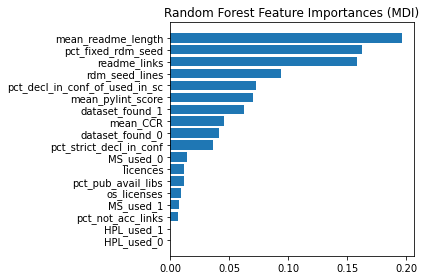

In [16]:
ohe = rf.named_steps["preprocess"].named_transformers_["cat"]
feature_names = ohe.get_feature_names_out(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = rf.named_steps["classifier"].feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

## Final Feature Importance Scores

As already discussed, we performed the above process several times (ten times) and averaged the values obtained. We have documented the results of each pass along with the seed used in feature_importance_calculations.txt.

We saved these average values ​​in feature_importance_means.csv. The final plot is then created using this file (see below).

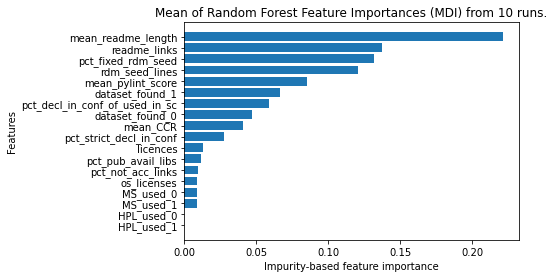

In [17]:
import csv
  
x = []
y = []
  
with open('feature_importance_means.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
      
    for row in plots:
        y.append(row[0])
        x.append(float(row[1]))

plt.barh(y,x)
plt.title('Mean of Random Forest Feature Importances (MDI) from 10 runs.')
plt.ylabel('Features')
plt.xlabel('Impurity-based feature importance')
plt.savefig("MDI.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Plot Interpretation


Before one evaluates this plot, it should be clear what exactly these values mean. The larger the displayed value of a feature, the more important it is for the correct determination of the target value (reproducible or non-reproducible). It is important to mention here that numerical values are preferred by the MDI approach (MDI feature selection bias).

However, as already discussed in the introduction sections of this notebook, this is not particularly important for us, since we are interested in checking the weights chosen for the indicators of a factor. In Chapter 6 of the thesis, we presented our approach to connecting the factors with the assigned indicators. If a factor has multiple indicators, it is important to determine the impact of each indicator on the overall factor. For this purpose, we justified our chosen weights with the help of statistical analysis and additional argumention. 

With the help of the determined feature importance scores, we can check whether the weights we assigned agree with these results. In Chapter 7 of the thesis, we use this plot and the determined scores.